$$\text{
Importing the Necessary Libraries
}
$$

In [ ]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist


$$\text{
Setting Global Varables
}
$$

In [ ]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  3811 # 18147 - 56*256
ALPHA = 0.001
EPOCHS = 100
BATCH_SIZE = 256

# set location of input files and output files
inpDir = '../input/fashion_mnist'
outDir = '../output'
modelDir = '../models' 


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




$$\text{
    Loading the data
}
$$

In [ ]:
train_df = pd.read_csv(os.path.join(inpDir, 'fashion-mnist_train.csv'))
test_df = pd.read_csv(os.path.join(inpDir, 'fashion-mnist_test.csv'))
 

train_df.shape, test_df.shape

((60000, 785), (10000, 785))

$$\text{
    Train Test Split
}
$$

In [45]:
X_train, y_train= train_df.drop(columns=['label']), train_df['label']
X_test, y_test= test_df.drop(columns=['label']), test_df['label']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

$$\text{
    Scaling the Dataset
}
$$

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

$$
\text{
Converting to dataset for batch processing instead of all data training at once
}
$$

In [46]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

type(train_ds), type(test_ds)

(tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset)

$$
\text{
    Converting the data to a tensor dataset using Preprocessing and Batching
}
$$

In [47]:
train_ds = train_ds.shuffle(buffer_size = X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size = X_test.shape[0]).batch(BATCH_SIZE)

In [48]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
# ONly for testing
next(iter(train_ds))

(<tf.Tensor: shape=(256, 784), dtype=int64, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)>,
 <tf.Tensor: shape=(256,), dtype=int64, numpy=
 array([1, 7, 5, 9, 2, 4, 3, 2, 9, 8, 8, 0, 5, 9, 2, 6, 8, 2, 5, 8, 8, 8,
        9, 3, 3, 6, 0, 6, 9, 4, 8, 8, 6, 8, 8, 0, 2, 7, 7, 0, 6, 4, 8, 3,
        6, 3, 2, 2, 1, 7, 0, 5, 9, 7, 9, 9, 9, 8, 0, 7, 5, 0, 1, 5, 0, 1,
        5, 5, 8, 5, 2, 5, 0, 0, 0, 1, 1, 9, 5, 3, 6, 1, 4, 4, 9, 3, 9, 0,
        3, 5, 8, 0, 0, 2, 9, 2, 2, 3, 4, 7, 6, 1, 4, 5, 9, 8, 4, 2, 5, 6,
        7, 9, 4, 9, 6, 1, 1, 5, 9, 4, 8, 9, 9, 6, 5, 4, 8, 9, 4, 5, 2, 6,
        5, 1, 4, 0, 9, 8, 6, 4, 4, 8, 7, 0, 5, 6, 6, 1, 5, 5, 6, 1, 8, 7,
        7, 2, 9, 0, 7, 6, 2, 7, 1, 9, 2, 3, 2, 7, 1, 1, 6, 8, 4, 1, 0, 6,
        2, 9, 6, 7, 4, 3, 5, 6, 1, 1, 8, 5, 5, 4, 5, 1, 8, 6, 0, 3, 1, 0,
        5

$$\text{
    Creating the model
}
$$

In [50]:
in_len = X_train.shape[1]
out_len = len(y_train.value_counts())

model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_len,), name = 'input'), 
    tf.keras.layers.Dense(18, activation = 'leaky_relu', name = 'fc_1'), 
    tf.keras.layers.Dense(out_len, name = 'output')
])

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                    │ (None, 18)             │        14,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,320 (55.94 KB)

 Trainable params: 14,320 (55.94 KB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [53]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [54]:
prediction = model(X_train).numpy().sum()

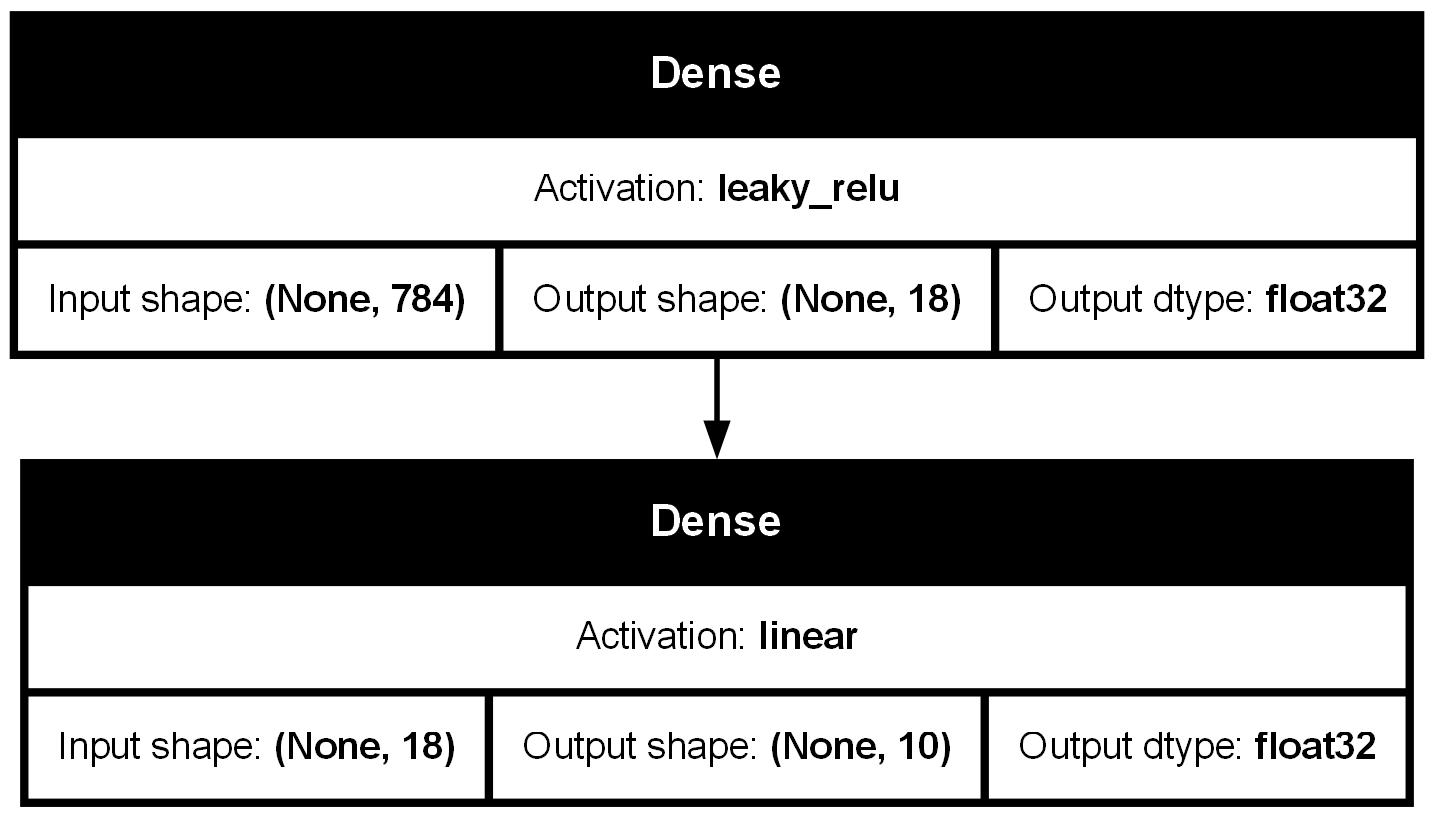

In [55]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'multilayer_fifa.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

$$\text{
    Compiling the model
}
$$

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [57]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5342 - loss: 32.7424 - val_accuracy: 0.7127 - val_loss: 3.8319
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7455 - loss: 3.0786 - val_accuracy: 0.7450 - val_loss: 2.5779
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7668 - loss: 2.1486 - val_accuracy: 0.7688 - val_loss: 1.9201
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7828 - loss: 1.6782 - val_accuracy: 0.7730 - val_loss: 1.7062
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7877 - loss: 1.4897 - val_accuracy: 0.7885 - val_loss: 1.4654
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7950 - loss: 1.3038 - val_accuracy: 0.8031 - val_loss: 1.2906
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8041 - loss: 1.1376 - val_accuracy: 0.7871 - val_loss: 1.2619
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8057 - loss: 1.0739 - val_acc

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.651833,12.440222,0.7127,3.831889
1,0.754033,2.720310,0.7450,2.577922
2,0.772617,1.997119,0.7688,1.920073


,accuracy,loss,val_accuracy,val_loss
97,0.881950,0.328735,0.8533,0.512112
98,0.881417,0.326749,0.8463,0.529080
99,0.880117,0.331747,0.8552,0.494295


<Axes: >

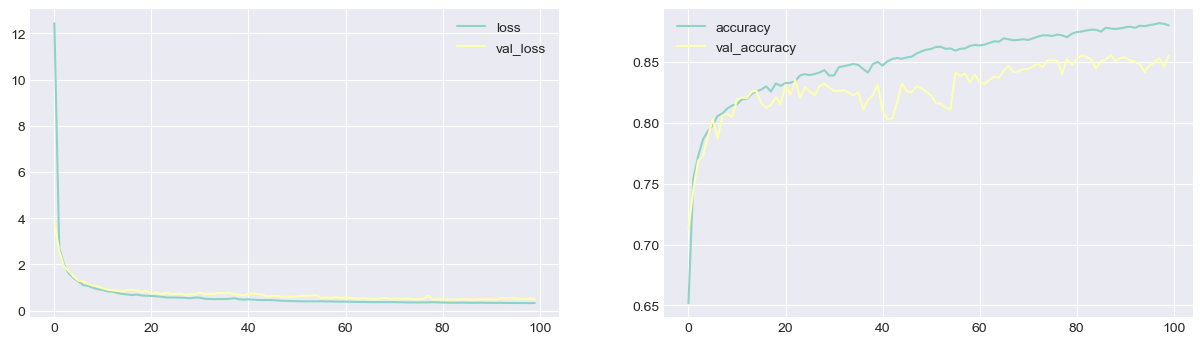

In [58]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fig, axes = plt.subplots(1,2)
hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])

In [59]:
pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.651833,12.440222,0.7127,3.831889
1,0.754033,2.720310,0.7450,2.577922
2,0.772617,1.997119,0.7688,1.920073
3,0.786467,1.609297,0.7730,1.706150
4,0.793167,1.402941,0.7885,1.465365
...,...,...,...,...
95,0.880250,0.333781,0.8471,0.526697
96,0.880950,0.329085,0.8495,0.510367
97,0.881950,0.328735,0.8533,0.512112
98,0.881417,0.326749,0.8463,0.529080


$$\text{
Creating the Prediction Model
}
$$

In [60]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 10)             │        14,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,320 (55.94 KB)

 Trainable params: 14,320 (55.94 KB)

 Non-trainable params: 0 (0.00 B)


$$
\text{
    If train dataframe is avaliable the only perform following steps 
}
$$

In [61]:
y_pred = model.predict(X_train)
accuracy_score(y_true= y_train, y_pred = y_pred.argmax(axis=1))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


0.87985

$$
\text{
Train Data Accuracy and Confusion Matrix
}
$$

In [62]:
y_true, y_pred = [], []
for count, data in enumerate(train_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(60000, 60000)

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      6000
           1       0.99      0.97      0.98      6000
           2       0.82      0.76      0.79      6000
           3       0.83      0.93      0.88      6000
           4       0.84      0.72      0.77      6000
           5       0.99      0.97      0.98      6000
           6       0.62      0.79      0.69      6000
           7       0.96      0.95      0.95      6000
           8       0.98      0.97      0.97      6000
           9       0.95      0.98      0.96      6000

    accuracy                           0.88     60000
   macro avg       0.89      0.88      0.88     60000
weighted avg       0.89      0.88      0.88     60000



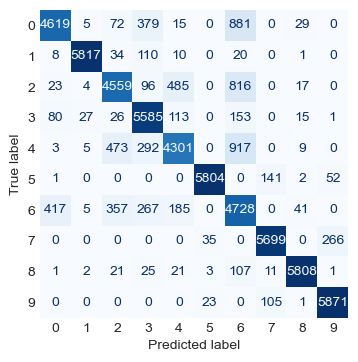

In [69]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(y_train.unique()))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
ax.grid(False)

$$
\text{
Test Data Accuracy and Confusion Matrix
}
$$

In [70]:
y_true, y_pred = [], []
for count, data in enumerate(test_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(10000, 10000)

In [71]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.8552

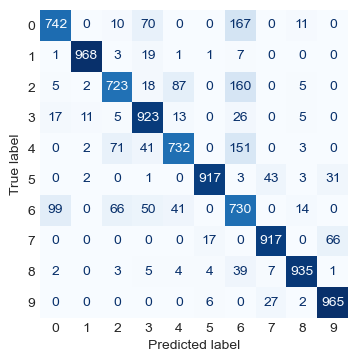

In [73]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(y_train.unique()))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
ax.grid(False)